### Example code for Remote Python Pizza Hamburg 2021
### https://github.com/mborus/python_pizza_2021
## "I can show you that on a map"
### Martin Borus (@mborus)

In [1]:
import pandas as pd
import locale

In [2]:
import pgeocode
from h3 import h3

In [3]:
import geopandas as gpd
import folium
import branca.colormap as cm
from shapely.geometry import Point
from shapely.geometry import Polygon


## Example for pgeocode

In [4]:
# If you have SSL Error: On windows, update Let's Encrypt Root Cert or patch pgeocode
# note: needs: context=ssl._create_unverified_context()) 
# in line 141 of pgeocode.py
# Note: This library creates a "pgeocode" folder in your home directory

nomi = pgeocode.Nominatim('DE')

nomi.query_postal_code(['24937', '25980'])[
    ['postal_code','country_code', 'place_name', 'latitude', 'longitude', 'accuracy']]


,postal_code,country_code,place_name,latitude,longitude,accuracy
0,24937,DE,Flensburg,54.7862,9.4306,4.0
1,25980,DE,"Westerland, Rantum, Sylt-Ost",54.9079,8.3360,4.0


## Example for H3

In [5]:
# Flensburg

H3_RESOLUTION = 5

h3_string = h3.geo_to_h3(54.7862 ,9.4306, H3_RESOLUTION)

h3_string

'851f3177fffffff'

In [6]:
h3.h3_to_geo_boundary(h3_string, True)

((9.371420013736138, 54.87004046378097),
 (9.382614837583992, 54.79381950102443),
 (9.51378422426026, 54.76746529083495),
 (9.634048551476907, 54.817303201602805),
 (9.623148495706317, 54.893561089302615),
 (9.491688921177275, 54.91994430460952),
 (9.371420013736138, 54.87004046378097))

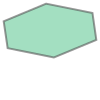

In [7]:
Polygon(h3.h3_to_geo_boundary(h3_string, True))

# Full 3 step map creating example

In [8]:
# run example
df = pd.read_csv('sample_turnover_germany.csv', sep='|', encoding='utf-8',  dtype='str')

# set comma & thousands decimals correct according to data source
locale.setlocale(0, 'US')
df['turnover(EUR)'] = df['turnover(EUR)'].map(locale.atof)

In [9]:
# show some of the imported lines
df.sample(5)

,zipcode,country,turnover(EUR)
5995,06126,DE,650.43
8397,97514,DE,351.84
3007,73257,DE,563.92
604,10974,DE,31.13
4982,72760,DE,749.19


In [10]:
def step1_geocoding(df):
    # series: group by zipcode, sum the turnover 
    s_zipcode = df.groupby('zipcode')['turnover(EUR)'].sum()
    
    # receive geodata dataframe from pgeocode
    df_geometry = nomi.query_postal_code(list(s_zipcode.index))[['longitude', 'latitude']]
    
    # add column zipcode, turnover 
    df_geometry['zipcode'] = s_zipcode.index
    df_geometry['turnover(EUR)'] = s_zipcode.values
    
    return df_geometry
    

In [11]:
def step2_h3(df):
    
    H3_RESOLUTION = 5
    def lat_lng_to_h3(row):
        return h3.geo_to_h3(row.latitude,row.longitude, H3_RESOLUTION)
    
    def add_geometry(row):
        points = h3.h3_to_geo_boundary(row['h3'], True)
        return Polygon(points)

    df['h3'] = df.apply(lat_lng_to_h3, axis=1)
    
    df_h3_grouped = df.groupby(['h3'])['turnover(EUR)'].sum().to_frame('turnover(EUR)').reset_index()
    
    # watch out for data that couldn't get h3 encoded, it's in row 0
    df_h3_grouped = df_h3_grouped.iloc[1:].copy()
    df_h3_grouped['geometry'] = df_h3_grouped.apply(add_geometry, axis=1)
    return df_h3_grouped
    

In [12]:
def step3_create_gfd(df, save):
    MAX_AMOUNT_COLORMAP = 100_000
    
    gdf = gpd.GeoDataFrame(df, crs='EPSG:4326')
    
    # select a color map
    
    # colorful
    # colormap = cm.linear.Set2_05.scale(0, MAX_AMOUNT_COLORMAP).to_step(10)
    
    # fiery map
    colormap = cm.linear.YlOrRd_09.scale(0, MAX_AMOUNT_COLORMAP)
    
    colormap.caption = f"Example Data"
    
    # column for the colors
    gdf['cm'] = gdf['turnover(EUR)'].apply(colormap)
    
    # create the map for inline printing or saving
    m = gdf.explore(m = folium.Map(location=[50.523, 9], 
                                   tiles="cartodbpositron" ,
                                   zoom_start=6), 
                    color='cm', style_kwds={'stroke':False}, 
                    tooltip = ['turnover(EUR)'], 
                    legend=True,
                    vmax = MAX_AMOUNT_COLORMAP)
    
    m.add_child(colormap)
    
    if save:
        m.save(f"saved_map.html")

    return m

In [13]:
df1 = step1_geocoding(df)
df2 = step2_h3(df1)
m = step3_create_gfd(df2, save=False)

In [14]:
# show the map!
m